## Import necessary libraries

In [ ]:
# Amazon Fine Food Reviews

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# Set random seed for reproducibility
np.random.seed(42)

## Load Dataset

In [ ]:
import pandas as pd
import gdown

# File ID from Google Drive link
file_id = "1v9y0PvDwYVEzF9LBliyFfNC-8i5MGjjp"
file_name = "data.csv"

# Download the file from Google Drive
gdown.download(f"https://drive.google.com/uc?id={file_id}", file_name, quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=1v9y0PvDwYVEzF9LBliyFfNC-8i5MGjjp
From (redirected): https://drive.google.com/uc?id=1v9y0PvDwYVEzF9LBliyFfNC-8i5MGjjp&confirm=t&uuid=0deae600-c563-4e7a-80d6-cf9f31bcf3eb
To: /content/data.csv
100%|██████████| 301M/301M [00:02<00:00, 124MB/s]


'data.csv'

## View Sample Data

In [ ]:
df = pd.read_csv("data.csv")
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## 1. Select Important Columns


 - Load only the columns we need to save memory

In [ ]:
columns_we_need = ['Id', 'ProductId', 'Score', 'Text', 'Summary',
                   'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time']
df = df[columns_we_need]

print("Data loaded successfully!")
print("Total reviews loaded:", len(df))
df.head()  # Show a sample


Data loaded successfully!
Total reviews loaded: 568454


,Id,ProductId,Score,Text,Summary,HelpfulnessNumerator,HelpfulnessDenominator,Time
0,1,B001E4KFG0,5,I have bought several of the Vitality canned d...,Good Quality Dog Food,1,1,1303862400
1,2,B00813GRG4,1,Product arrived labeled as Jumbo Salted Peanut...,Not as Advertised,0,0,1346976000
2,3,B000LQOCH0,4,This is a confection that has been around a fe...,"""Delight"" says it all",1,1,1219017600
3,4,B000UA0QIQ,2,If you are looking for the secret ingredient i...,Cough Medicine,3,3,1307923200
4,5,B006K2ZZ7K,5,Great taffy at a great price. There was a wid...,Great taffy,0,0,1350777600


## 2. Creating a smaller sample (10,000 reviews)


  - Take 10,000 reviews total
  - Keep the same star rating proportions as original data
###(so if 50% were 5-star originally, our sample will have ~50% 5-star)

In [ ]:
# Check original star rating percentages
star_percentages = df['Score'].value_counts(normalize=True)

# Take proportional samples for each star rating (1-5)
sample = pd.concat([
    df[df['Score'] == 1].sample(n=int(10000 * star_percentages[1]), random_state=42),
    df[df['Score'] == 2].sample(n=int(10000 * star_percentages[2]), random_state=42),
    df[df['Score'] == 3].sample(n=int(10000 * star_percentages[3]), random_state=42),
    df[df['Score'] == 4].sample(n=int(10000 * star_percentages[4]), random_state=42),
    df[df['Score'] == 5].sample(n=int(10000 * star_percentages[5]), random_state=42)
])

# Make sure we have exactly 10,000 (sometimes rounding gives 10,001)
if len(sample) > 10000:
    sample = sample.sample(n=10000, random_state=42)

print("\nSample created successfully!")
print("Star distribution in our sample:")
print(sample['Score'].value_counts(normalize=True).sort_index())


Sample created successfully!
Star distribution in our sample:
Score
1    0.091928
2    0.052316
3    0.075023
4    0.141843
5    0.638892
Name: proportion, dtype: float64


## 3. Cleaning the data
  - Remove reviews with empty text
  - Fill empty summaries with blank strings
  - Remove duplicate reviews (same text appearing multiple times)
  - Convert review timestamps to year.
  - Create a Helpfulness ratio feature.

In [ ]:
# Show missing values before cleaning
print("\nMissing values before cleaning:")
print("Empty text fields:", sample['Text'].isnull().sum())
print("Empty summary fields:", sample['Summary'].isnull().sum())

# Remove reviews with no text
clean_data = sample.dropna(subset=['Text'])

# Fill empty summaries with "" (blank)
clean_data['Summary'] = clean_data['Summary'].fillna("")

# Remove duplicate reviews
initial_count = len(clean_data)
clean_data = clean_data.drop_duplicates(subset=['Text'])
duplicates_removed = initial_count - len(clean_data)

# Convert Time to Year
clean_data['Year'] = pd.to_datetime(clean_data['Time'], unit='s').dt.year

# Create Helpfulness ratio feature
clean_data['Helpfulness'] = clean_data.apply(
    lambda row: row['HelpfulnessNumerator'] / row['HelpfulnessDenominator']
    if row['HelpfulnessDenominator'] != 0 else 0,
    axis=1
)

# Show results after cleaning
print("\nAfter cleaning:")
print("Removed", duplicates_removed, "duplicate reviews")
print("Final cleaned review count:", len(clean_data))




Missing values before cleaning:
Empty text fields: 0
Empty summary fields: 0

After cleaning:
Removed 179 duplicate reviews
Final cleaned review count: 9818


## 4. Adding sentiment labels

### Convert star ratings to simple categories:
  - 1-2 stars = Negative
  - 3 stars = Neutral
  - 4-5 stars = Positive

In [ ]:
clean_data['Sentiment'] = clean_data['Score'].map({
    1: 'Negative',
    2: 'Negative',
    3: 'Neutral',
    4: 'Positive',
    5: 'Positive'
})

print("\nSentiment distribution:")
print(clean_data['Sentiment'].value_counts())


Sentiment distribution:
Sentiment
Positive    7673
Negative    1413
Neutral      732
Name: count, dtype: int64


## 5. Cleaning the review text

### For both 'Text' and 'Summary' fields:
 -  1. Convert to lowercase
 -  2. Remove punctuation and numbers
 -  3. Remove very short words
 -  4. Add New Feature: Word_Count = Number of words in each cleaned review

In [ ]:
import re

def clean_text(text):
    text = str(text).lower()  # Make everything lowercase
    text = re.sub(r'[^a-z\s]', '', text)  # Remove non-letters
    text = ' '.join([word for word in text.split() if len(word) > 2])  # Keep only longer words
    return text

# Apply cleaning to both text fields
clean_data['Cleaned_Text'] = clean_data['Text'].apply(clean_text)
clean_data['Cleaned_Summary'] = clean_data['Summary'].apply(clean_text)

# Add word count feature
clean_data['Word_Count'] = clean_data['Cleaned_Text'].str.split().str.len()


# Show example before/after cleaning
print("\nText cleaning example:")
print("Original:", clean_data['Text'].iloc[0][:50], "...")
print("Cleaned:", clean_data['Cleaned_Text'].iloc[0][:50], "...")

# Show word count stats
print("\nWord Count Statistics:")
print(clean_data['Word_Count'].describe())


Text cleaning example:
Original: If you like the (bitter) taste of Sweet & Low, get ...
Cleaned: you like the bitter taste sweet low get this you d ...

Word Count Statistics:
count    9818.000000
mean       60.633327
std        57.413338
min         5.000000
25%        26.000000
50%        44.000000
75%        75.000000
max      1269.000000
Name: Word_Count, dtype: float64


## Save cleaned dataset

In [ ]:
# Save cleaned data
clean_data.to_csv("cleaned_reviews.csv", index=False)
print("\nCleaned data saved as 'cleaned_reviews.csv'.")


Cleaned data saved as 'cleaned_reviews.csv'.


## 6. Exploratory Data Analysis (EDA)

## Distribution of Sentiment Labels
Most reviews are positive. There are fewer neutral and negative reviews, which might make it harder for models to predict them correctly.

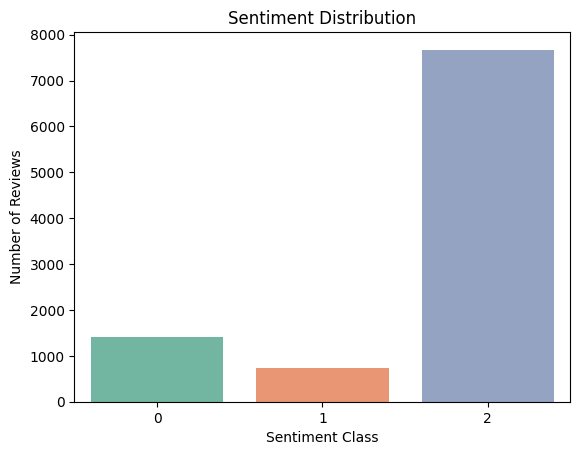

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='Sentiment', data=clean_data, hue='Sentiment', palette='Set2', legend=False)
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment Class")
plt.ylabel("Number of Reviews")
plt.show()

## Star Rating Distribution
Most reviews are rated 5 stars. Lower star ratings are much less common, showing that most customers left positive feedback.

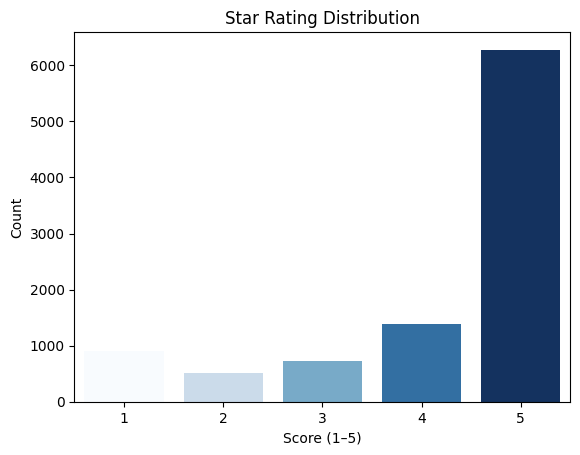

In [ ]:
sns.countplot(x='Score', data=clean_data, hue='Score', palette='Blues', legend=False)
plt.title("Star Rating Distribution")
plt.xlabel("Score (1–5)")
plt.ylabel("Count")
plt.show()

## Sentiment vs. Star Rating

Lower star ratings mostly match negative sentiment labels while higher star ratings match positive sentiment. Neutral reviews mainly appear at 3 stars.

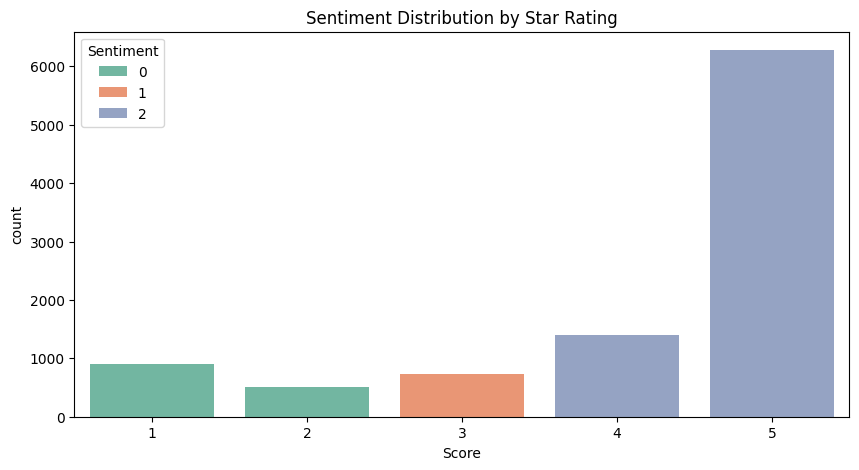

In [ ]:
plt.figure(figsize=(10, 5))
sns.countplot(x='Score', hue='Sentiment', data=clean_data, palette='Set2')
plt.title("Sentiment Distribution by Star Rating")
plt.show()

## Plot Review Counts Over Time
The number of reviews grew each year with a big jump around 2010–2012. This shows Amazon's food review platform became much more active over time.

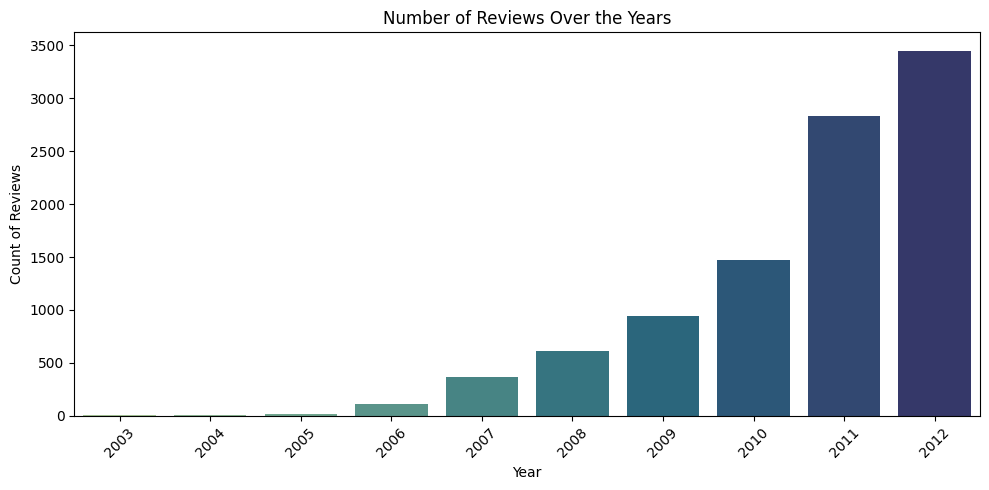

In [ ]:
plt.figure(figsize=(10, 5))
sns.countplot(data=clean_data, x='Year', hue='Year', palette='crest', legend=False)
plt.title("Number of Reviews Over the Years")
plt.ylabel("Count of Reviews")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Plot Sentiment Over Time
Positive reviews increased each year and were always the most common. Negative and neutral reviews also grew a bit but positive reviews were always the most frequent.

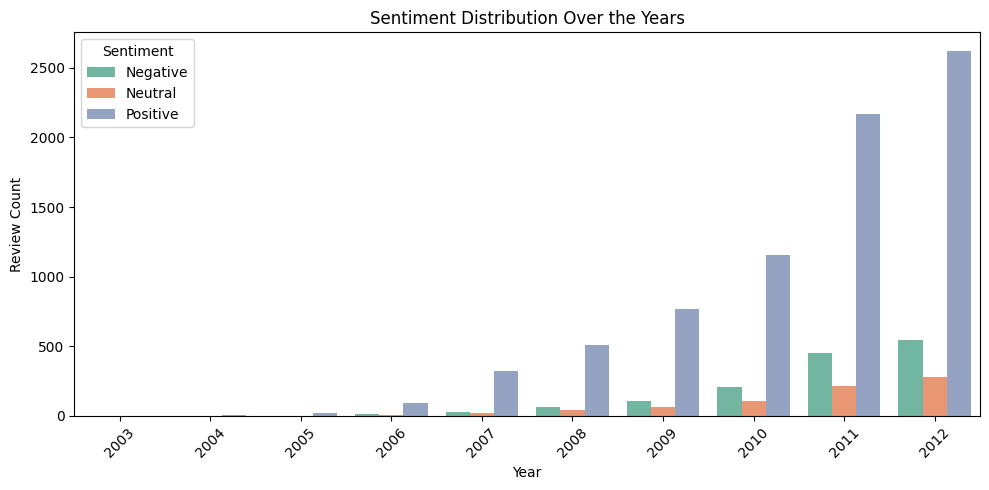

In [ ]:
plt.figure(figsize=(10, 5))
sns.countplot(data=clean_data, x='Year', hue='Sentiment', palette='Set2')
plt.title("Sentiment Distribution Over the Years")
plt.ylabel("Review Count")
plt.xticks(rotation=45)
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()

## Sentiment Trend Over Years
Positive reviews grew over the years while negative and neutral reviews stayed low and stable.

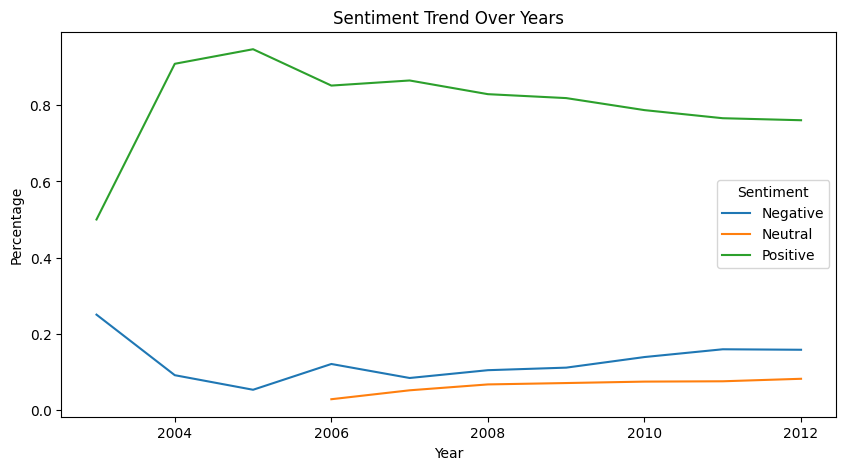

In [ ]:
yearly_stats = clean_data.groupby('Year')['Sentiment'].value_counts(normalize=True).unstack()
yearly_stats.plot(kind='line', figsize=(10, 5))
plt.title("Sentiment Trend Over Years")
plt.ylabel("Percentage")
plt.show()

## Word Count Distribution
The word count of reviews is highly skewed with most reviews being short (fewer than 100 words) while only a few reviews exceed 200 words.

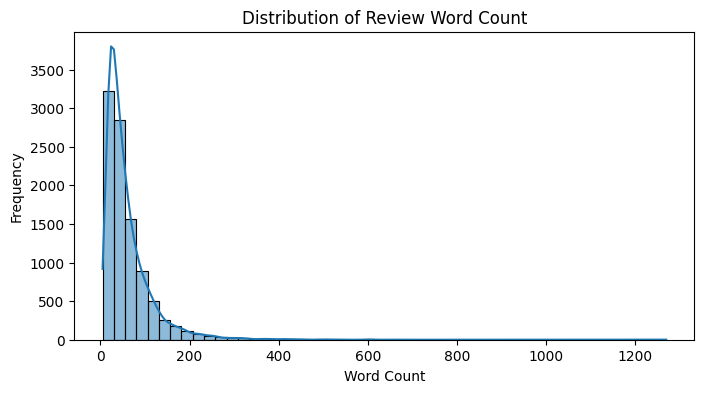

In [ ]:
plt.figure(figsize=(8, 4))
sns.histplot(clean_data['Word_Count'], bins=50, kde=True)
plt.title("Distribution of Review Word Count")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()

## Correlation Heatmap
The correlation heatmap shows how star ratings (Score) relate to both word count and helpfulness. The insights are that review length doesn’t affect star ratings, ratings don’t impact helpfulness, and longer reviews are slightly more likely to be helpful.

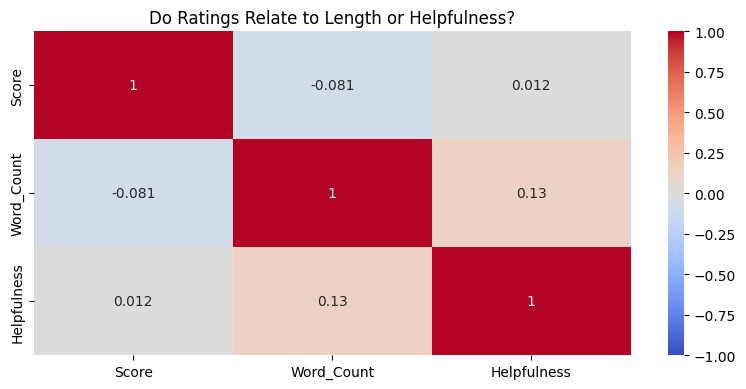

In [ ]:
plt.figure(figsize=(8, 4))
sns.heatmap(clean_data[['Score', 'Word_Count', 'Helpfulness']].corr(),
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Do Ratings Relate to Length or Helpfulness?")
plt.tight_layout()
plt.show()

## Boxplot of Word Count by Sentiment
This boxplot shows the word count distribution for each sentiment (Negative, Neutral, Positive). It highlights the spread and median word count for each sentiment group.

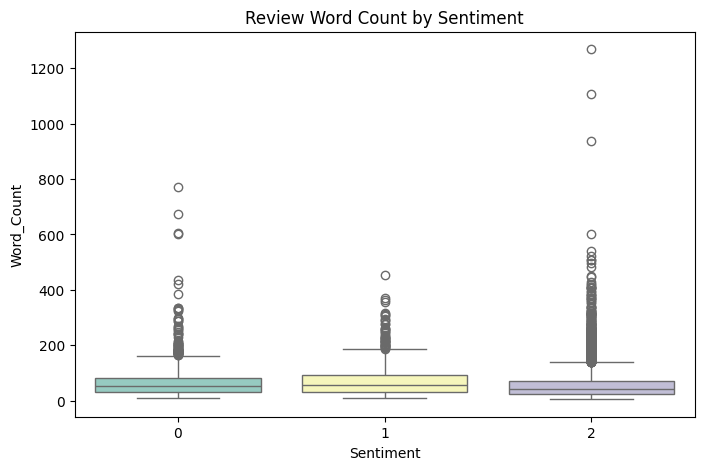

In [ ]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='Sentiment', y='Word_Count', data=clean_data, hue='Sentiment', palette='Set3', legend=False)
plt.title("Review Word Count by Sentiment")
plt.show()

## Word Cloud of Cleaned Review Text
The word cloud shows the most common words in the reviews. Bigger words like “taste,” “good,” “product” show up more often, meaning these are the words people mention most in their reviews.

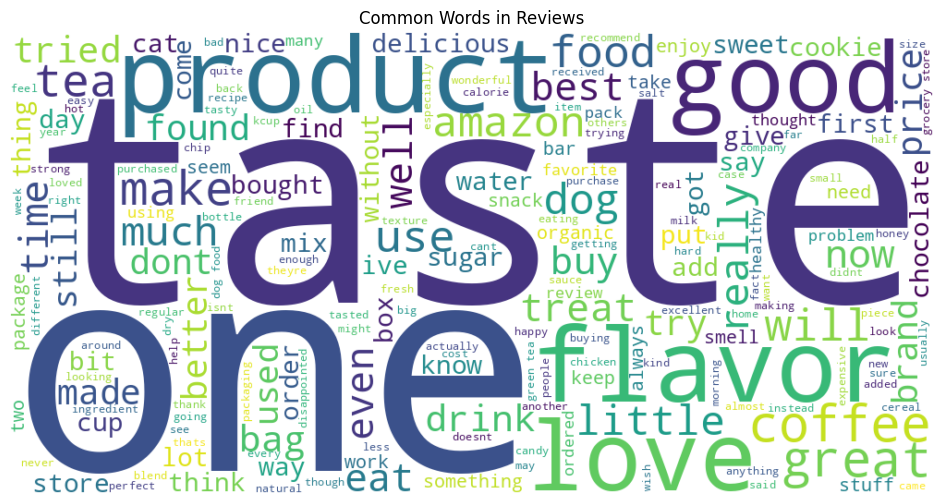

In [ ]:
from wordcloud import WordCloud

text = " ".join(clean_data['Cleaned_Text'])
wordcloud = WordCloud(width=1000, height=500, background_color='white').generate(text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Common Words in Reviews")
plt.show()

## Top 10 Words by Sentiment

The plot shows the top 10 most frequent words used in text data categorized into Negative,Neutral, and Positive sentiments.

 -	Negative: For negative sentiment, words like "the", "and", "this" appear most often.
 -	Neutral: Similarly, for neutral sentiment, "the", "and", "this" are also the most frequent.
 -	Positive: For positive sentiment, "the", "and", "this", "for" are the most common words


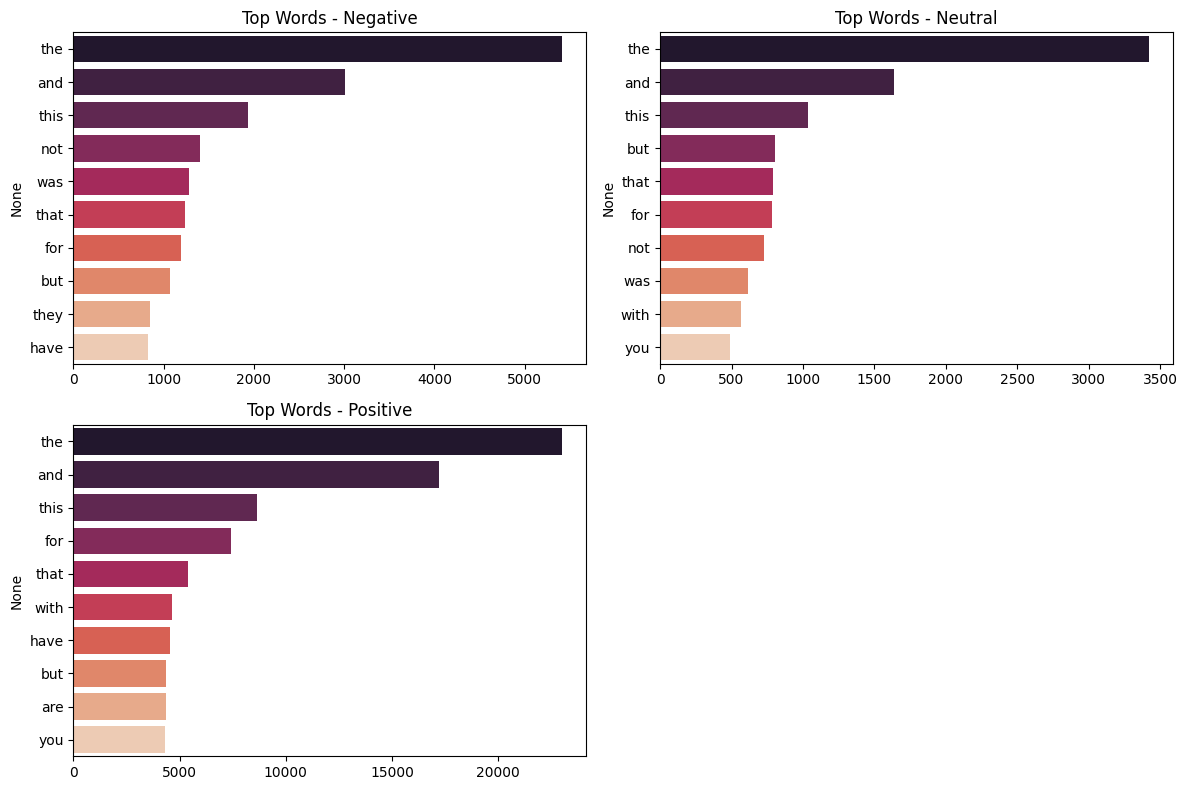

In [ ]:
# Top 10 Words by Sentiment

# Define the list of sentiments
sentiments = ['Negative', 'Neutral', 'Positive']
plt.figure(figsize=(12, 8))
for i, sentiment in enumerate(sentiments):
    words = " ".join(clean_data[clean_data['Sentiment']==sentiment]['Cleaned_Text']).split()
    top_words = pd.Series(words).value_counts().head(10)

    plt.subplot(2, 2, i+1)
    sns.barplot(x=top_words.values,
                y=top_words.index,
                hue=top_words.index,
                palette='rocket',
                legend=False)
    plt.title(f"Top Words - {sentiment}")
plt.tight_layout()
plt.show()

## Review Length Density
This plot shows the review length for each sentiment (negative, neutral, positive). Most reviews are short, with little difference in length across sentiment categories.

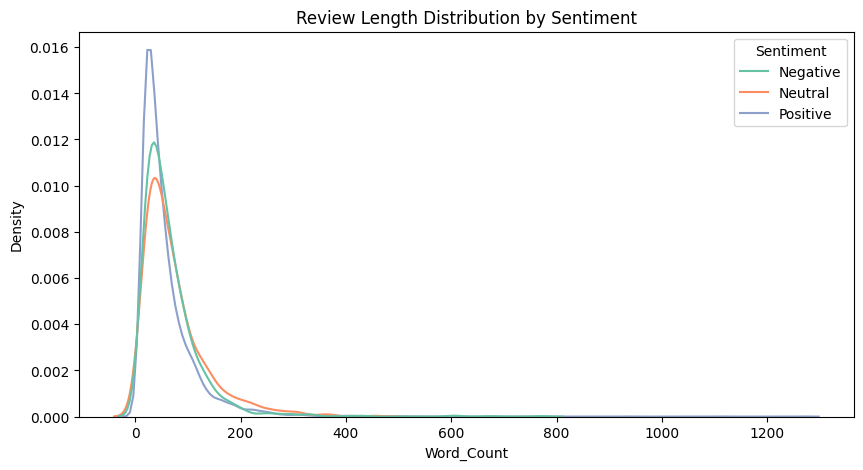

In [ ]:
# Review Length Density
plt.figure(figsize=(10, 5))
sns.kdeplot(data=clean_data, x='Word_Count', hue='Sentiment',
           palette='Set2', common_norm=False)
plt.title("Review Length Distribution by Sentiment")
plt.show()


## Summary of key statistics

Positive reviews are the most common and have high ratings (avg. 4.8 stars). Negative ones are few and rated low (avg. 1.3 stars). Neutral reviews are rare and fall in the middle.

Negative and neutral reviews are longer, while positive ones are shorter. This shows unhappy or unsure customers tend to write more.

There’s a class imbalance most reviews are positive. This may affect model performance.

In [ ]:
# Key Statistics Table
print(" SUMMARY STATISTICS")
print(clean_data.groupby('Sentiment').agg({
    'Score': ['mean', 'median'],
    'Word_Count': ['mean', 'count']
}))

 SUMMARY STATISTICS
              Score        Word_Count      
               mean median       mean count
Sentiment                                  
Negative   1.363057    1.0  66.193206  1413
Neutral    3.000000    3.0  74.229508   732
Positive   4.818194    5.0  58.312394  7673


# 7. Modeling Approach

Different machine learning models are used to predict the sentiment of Amazon Fine Food Reviews:

- Logistic Regression (baseline)
- Random Forest Classifier (advanced)
- K-Nearest Neighbors (KNN) (additional model)

Each model is trained and evaluated separately and their performances are compared based on accuracy and F1 score.


# Baseline Model and Evaluation ( Logistic Regression )

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import pandas as pd

# TF-IDF conversion
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
X = tfidf.fit_transform(df['Text'])

# Target variable
y = df['Score'].apply(lambda x: 1 if x >= 3 else 0)

# Split the dataset into training and testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the Logistic Regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict the sentiment for the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Classification report
classification_rep = classification_report(y_test, y_pred, output_dict=True)

results_df = pd.DataFrame(classification_rep).transpose()

# Print results
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

# Display Precision and Recall per class
print("\nPrecision/Recall per class:")
print(results_df)

# Error analysis
misclassified = df.iloc[y_test.index][y_test != y_pred]
print("\nMisclassified Examples:")
print(misclassified[['Text', 'Score']])

Accuracy: 0.9180
F1 Score: 0.9532
Confusion Matrix:
[[ 14184  10094]
 [  3885 142374]]

Precision/Recall per class:
              precision    recall  f1-score       support
0              0.784991  0.584233  0.669894   24278.00000
1              0.933796  0.973438  0.953205  146259.00000
accuracy       0.918030  0.918030  0.918030       0.91803
macro avg      0.859393  0.778835  0.811549  170537.00000
weighted avg   0.912612  0.918030  0.912872  170537.00000

Misclassified Examples:
                                                     Text  Score
433954  First there was Frosted Mini-Wheats, in origin...      2
492897  It sure would be nice if they stated ANYWHERE ...      1
179195  Okay, I jumped the gun, because they were send...      4
234760  I bought this item for my dog to play with. Sh...      1
363913  Edit: I've given this three stars vs my previo...      3
...                                                   ...    ...
541508  I ordered triple chocolate crunch bars and rec..

# Advanced Model and Comparison ( Random Forest Classifier )

Accuracy: 0.8024439918533605
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.19      0.30       290
           1       0.00      0.00      0.00       145
           2       0.80      0.99      0.89      1529

    accuracy                           0.80      1964
   macro avg       0.52      0.39      0.40      1964
weighted avg       0.74      0.80      0.74      1964

Confusion Matrix:
[[  55    0  235]
 [  11    0  134]
 [   8    0 1521]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


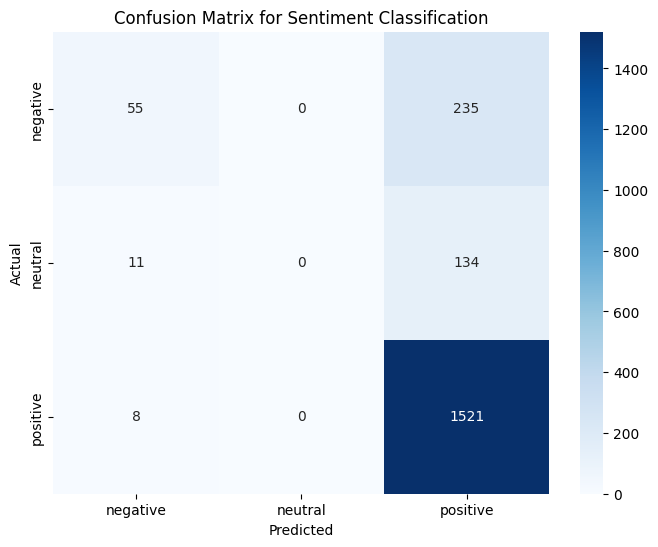

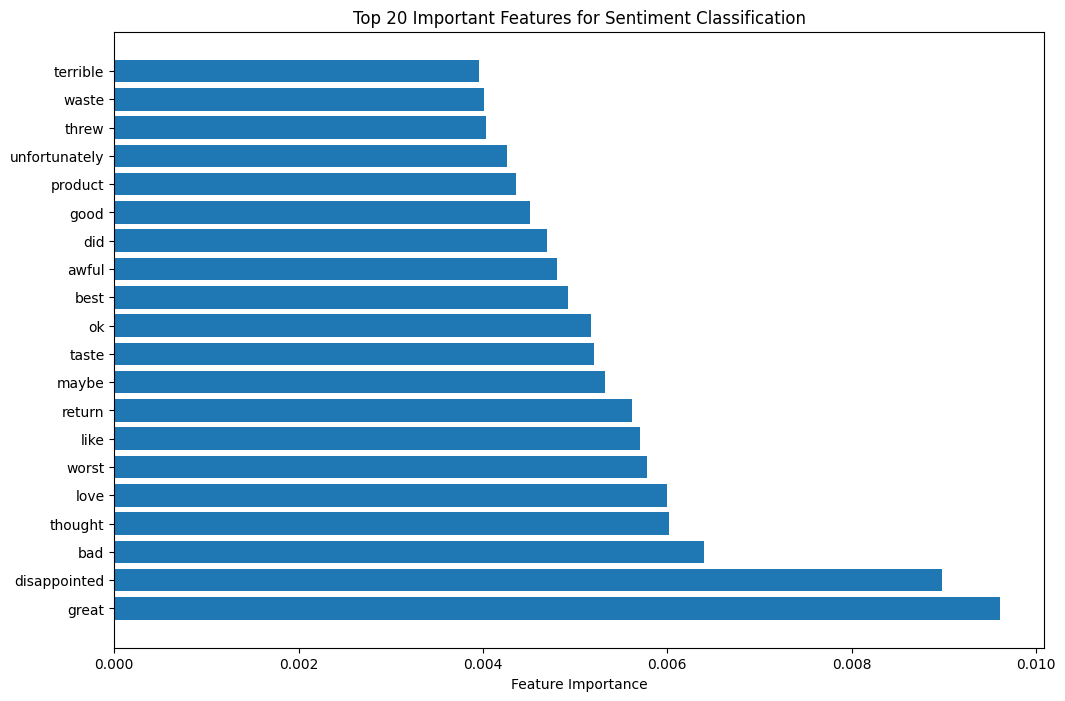

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

if 'Text' not in clean_data.columns or 'Score' not in clean_data.columns:
    print("Ensure that 'Text' and 'Score' columns exist in the dataset.")
else:
    # Create sentiment labels based on the review score (1-2 is negative, 3 is neutral, 4-5 is positive)
    def sentiment_label(score):
        if score <= 2:
            return 'negative'
        elif score == 3:
            return 'neutral'
        else:
            return 'positive'

    clean_data['Sentiment'] = clean_data['Score'].apply(sentiment_label)

    # encode the sentiment labels into numerical values
    label_encoder = LabelEncoder()
    clean_data['Sentiment'] = label_encoder.fit_transform(clean_data['Sentiment'])

    # convert text data into numerical form using TF-IDF
    tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
    X = tfidf_vectorizer.fit_transform(clean_data['Text'])

    # target variable (sentiment labels)
    y = clean_data['Sentiment']

    # Split the data into training and testing sets (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Random Forest Classifier model
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

    # train the model
    rf_model.fit(X_train, y_train)

    # predictions on the test set
    y_pred = rf_model.predict(X_test)

    # model's performance
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    # evaluation metrics
    print(f"Accuracy: {accuracy}")
    print(f"Classification Report:\n{class_report}")
    print(f"Confusion Matrix:\n{conf_matrix}")

    # Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix for Sentiment Classification')
    plt.show()

    # Feature Importances
    feature_importances = rf_model.feature_importances_
    indices = np.argsort(feature_importances)[::-1]

    plt.figure(figsize=(12, 8))

    plt.barh(range(20), feature_importances[indices][:20], align='center')
    plt.yticks(range(20), np.array(tfidf_vectorizer.get_feature_names_out())[indices][:20])
    plt.xlabel('Feature Importance')
    plt.title('Top 20 Important Features for Sentiment Classification')
    plt.show()

Comparing Random Forest Model to Logistic Regression Model

The Random Forest Classifier takes accuracy to be about 80% and most reviews seemed to be leaning more towards the positive side of the spectrum.
The Logistic Regression model accuracy was about 90% with an F1 score of 0.9532.

## KNN model

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Train/Test split (using same TF-IDF features)
X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(X, y, test_size=0.2, random_state=42)

# KNN model
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_knn, y_train_knn)

# Predictions
y_pred_knn = knn.predict(X_test_knn)

# Results
print("KNN Accuracy:", accuracy_score(y_test_knn, y_pred_knn))
print("\nClassification Report:\n", classification_report(y_test_knn, y_pred_knn))
print("\nConfusion Matrix:\n", confusion_matrix(y_test_knn, y_pred_knn))

KNN Accuracy: 0.7683299389002036

Classification Report:
               precision    recall  f1-score   support

           0       0.39      0.15      0.21       290
           1       0.11      0.03      0.04       145
           2       0.80      0.96      0.87      1529

    accuracy                           0.77      1964
   macro avg       0.44      0.38      0.38      1964
weighted avg       0.69      0.77      0.72      1964


Confusion Matrix:
 [[  43   15  232]
 [  17    4  124]
 [  51   16 1462]]
